### Machine Learning Major Research Project

Researcher: Alistair Clarke

Season: Fall 2018

In this research project, we will look at an ML program which classifies fruit images and determines the correct type or class of fruit the image belongs too.

Project Scope:

- Image Data Augmentation
- Different Models (Neural Networks)
- Features (Pre-Trained CNN Features)

Project Variables

- Kaggle's Fruit365 Dataset
- Google Downloaded Fruit Dataset
- Google Downloaded Augmented Fruit Dataset

Number and Sequence of Iterations

1. Google Downloaded Fruit Dataset
2. Google Downloaded Fruit Dataset with Kaggle Fruit365 Dataset
3. Google Downloaded Fruit Dataset with Augmented Google Downloaded Fruit Dataset
4. Google Downloaded Fruit Dataset with Augmented Google Downloaded Fruit Dataset and Kaggle Fruit365 Dataset

## Get the Data

In [0]:
# Import Necessary Libraries

import numpy as np 
import pandas as pd
import io

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D

Using TensorFlow backend.


### Mount Google Drive

- Enables file directory access

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Experiment 1: Train a simple Dense Neural Network using a Google Downloaded Fruit Dataset

- Dense Neural Network with 3 Input Layers and 64 units/nodes each
- Output: Softmax


In [0]:
from keras.applications import VGG16

# Load pretrained model VGG16
# Use weights from training on ImageNet
# Do not include the densely connected classifier 
# on top of the convolutional layers.
# include_top = false -> removes regular NN

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

#### Extract Features for Dense Network

- Using Pre-Trained CNN features to train Dense network

In [0]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Base Directory

base_dir = '../content/gdrive/My Drive/Fruit Classifier/google-fruits'

# Specify training, validation and testing directories

train_dir = base_dir + '/train'
valid_dir = base_dir + '/validation'
test_dir = base_dir + '/test'

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 5

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 6))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        # Product set of feature vectors
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 35)
validation_features, validation_labels = extract_features(valid_dir, 10)
test_features, test_labels = extract_features(test_dir, 5)

Found 210 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Found 30 images belonging to 6 classes.


#### Reshape outputted feature vectors to be fed into Neural Network

In [0]:
train_features = np.reshape(train_features, (35, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (10, 4 * 4 * 512))
test_features = np.reshape(test_features, (5, 4 * 4 * 512))

In [0]:
# Get shape dimensions of the training features

train_features.shape

(35, 8192)

#### Densely Connected Neural Network

- Fit and train to 3 layer-dense network to training data
- Evaluate against validation data
- Dropout of 50%

In [0]:
from keras import layers
from keras import models

def network_creation(train_features, train_labels, validation_features, validation_labels, test_features, test_labels, epochs):

  # Specify network type: Sequential Model

  simple_model = models.Sequential()

  # Define layers

  simple_model.add(layers.Dense(64, activation='relu', input_dim=(4*4*512)))

  simple_model.add(layers.Dense(64, activation='relu'))

  # Dropout layer (dropout 50%)

  simple_model.add(layers.Dropout(0.5))

  simple_model.add(layers.Dense(64, activation='relu'))

  # Output layer

  simple_model.add(layers.Dense(6, activation='softmax'))

  # Compile the network

  simple_model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  # Fit and train model
  
  history = simple_model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=5,
                    validation_data=(validation_features, validation_labels))
  
  return simple_model, history

In [0]:
# Create and train network

model, history = network_creation(train_features, train_labels, validation_features, validation_labels, test_features, test_labels, 30) 

Train on 35 samples, validate on 10 samples
Epoch 1/30
35/35 [==============================] - 0s 14ms/step - loss: 2.1987 - acc: 0.2571 - val_loss: 1.6681 - val_acc: 0.3000
Epoch 2/30
35/35 [==============================] - 0s 2ms/step - loss: 1.8983 - acc: 0.3714 - val_loss: 1.5141 - val_acc: 0.3000
Epoch 3/30
35/35 [==============================] - 0s 2ms/step - loss: 1.3607 - acc: 0.5143 - val_loss: 1.3211 - val_acc: 0.3000
Epoch 4/30
35/35 [==============================] - 0s 2ms/step - loss: 1.1044 - acc: 0.6000 - val_loss: 1.5738 - val_acc: 0.3000
Epoch 5/30
35/35 [==============================] - 0s 2ms/step - loss: 0.8979 - acc: 0.7143 - val_loss: 1.4424 - val_acc: 0.4000
Epoch 6/30
35/35 [==============================] - 0s 2ms/step - loss: 0.8115 - acc: 0.8000 - val_loss: 0.9554 - val_acc: 0.6000
Epoch 7/30
35/35 [==============================] - 0s 2ms/step - loss: 0.4782 - acc: 0.8571 - val_loss: 1.1473 - val_acc: 0.6000
Epoch 8/30
35/35 [===========================

In [0]:
# View network's structure

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                524352    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 533,062
Trainable params: 533,062
Non-trainable params: 0
_________________________________________________________________


#### Plotter Function

- Plots performance results from networks

In [0]:
import matplotlib.pyplot as plt

def plotter(hist):

  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

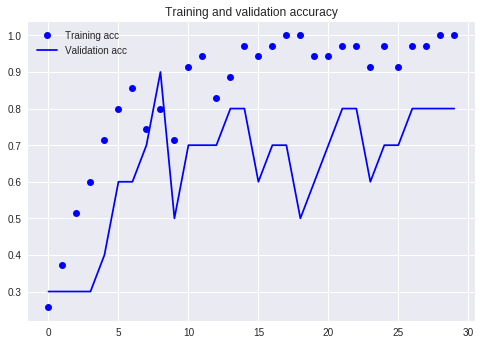

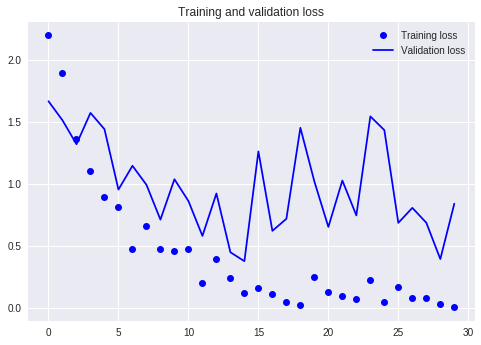

In [0]:
# Call Plotter Function to display the results

plotter(history)

### Observable Results

After running the model for 30 epochs/iterations, we obtained the following results:

- Training Accuracy: 100%
- Validation Accuracy: 80%

Used Parameters:
- No. of epochs: 30
- Batches: 5

### Experiment 2: Train a simple Dense Neural Network using a Google Downloaded Fruit Dataset with Kaggle Dataset

- Dense Neural Network with 3 Input Layers and 64 units/nodes each
- Output: Softmax


In [0]:
# Base Directory

base_dir = '../content/gdrive/My Drive/Fruit Classifier/google-fruits-kaggle-fruits'

# Specify training, validation and testing directories

train_dir = base_dir + '/train'
valid_dir = base_dir + '/validation'
test_dir = base_dir + '/test'

In [0]:
# Extract features and labels

train_features, train_labels = extract_features(train_dir, 35)
validation_features, validation_labels = extract_features(valid_dir, 10)
test_features, test_labels = extract_features(test_dir, 5)

Found 1583 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Found 30 images belonging to 6 classes.


In [0]:
# Reshape feature vectors to fit into ML models

train_features = np.reshape(train_features, (35, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (10, 4 * 4 * 512))
test_features = np.reshape(test_features, (5, 4 * 4 * 512))

# Get shape dimensions of the training features

train_features.shape

(35, 8192)

In [0]:
# Create new model

model, history = network_creation(train_features, train_labels, validation_features, validation_labels, test_features, test_labels, 30)

Train on 35 samples, validate on 10 samples
Epoch 1/30
35/35 [==============================] - 0s 10ms/step - loss: 2.4471 - acc: 0.2571 - val_loss: 1.9436 - val_acc: 0.1000
Epoch 2/30
35/35 [==============================] - 0s 2ms/step - loss: 1.5308 - acc: 0.4000 - val_loss: 2.0128 - val_acc: 0.0000e+00
Epoch 3/30
35/35 [==============================] - 0s 2ms/step - loss: 1.2770 - acc: 0.4857 - val_loss: 2.0957 - val_acc: 0.1000
Epoch 4/30
35/35 [==============================] - 0s 2ms/step - loss: 1.1489 - acc: 0.5714 - val_loss: 2.1986 - val_acc: 0.0000e+00
Epoch 5/30
35/35 [==============================] - 0s 2ms/step - loss: 1.1063 - acc: 0.5714 - val_loss: 2.1583 - val_acc: 0.0000e+00
Epoch 6/30
35/35 [==============================] - 0s 2ms/step - loss: 0.9497 - acc: 0.5714 - val_loss: 2.3635 - val_acc: 0.1000
Epoch 7/30
35/35 [==============================] - 0s 2ms/step - loss: 0.7630 - acc: 0.6571 - val_loss: 2.3921 - val_acc: 0.0000e+00
Epoch 8/30
35/35 [===========

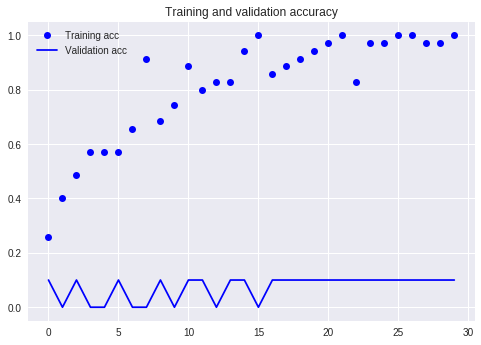

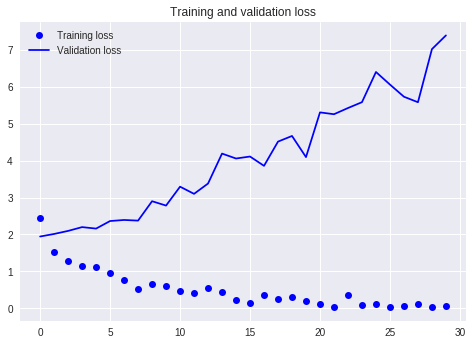

In [0]:
# Call Plotter Function to display the results

plotter(history)

### Observable Results

After running the model for 30 epochs/iterations, we obtained the following results:

- Training Accuracy: 100%
- Validation Accuracy: 1%

Used Parameters:

- No. of epochs: 30
- Batches: 5


### Experiment 3: Train a simple Dense Neural Network using a Google Downloaded Fruit Dataset with Google Downloaded Augmented Dataset

- Dense Neural Network with 3 Input Layers and 64 units/nodes each
- Output: Softmax


In [0]:
# Base Directory

base_dir = '../content/gdrive/My Drive/Fruit Classifier/google-fruits-augmented'

# Specify training, validation and testing directories

train_dir = base_dir + '/train'
valid_dir = base_dir + '/validation'
test_dir = base_dir + '/test'

In [0]:
# Extract features and labels

train_features, train_labels = extract_features(train_dir, 35)
validation_features, validation_labels = extract_features(valid_dir, 10)
test_features, test_labels = extract_features(test_dir, 5)

Found 1506 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Found 30 images belonging to 6 classes.


In [0]:
# Reshape feature vectors to fit into ML models

train_features = np.reshape(train_features, (35, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (10, 4 * 4 * 512))
test_features = np.reshape(test_features, (5, 4 * 4 * 512))

# Get shape dimensions of the training features

train_features.shape

(35, 8192)

In [0]:
# Create new model

model, history = network_creation(train_features, train_labels, validation_features, validation_labels, test_features, test_labels, 30)

Train on 35 samples, validate on 10 samples
Epoch 1/30
35/35 [==============================] - 0s 11ms/step - loss: 2.2159 - acc: 0.1714 - val_loss: 1.9437 - val_acc: 0.3000
Epoch 2/30
35/35 [==============================] - 0s 2ms/step - loss: 1.9130 - acc: 0.2571 - val_loss: 1.6034 - val_acc: 0.3000
Epoch 3/30
35/35 [==============================] - 0s 2ms/step - loss: 1.7444 - acc: 0.3143 - val_loss: 1.4153 - val_acc: 0.7000
Epoch 4/30
35/35 [==============================] - 0s 2ms/step - loss: 1.6080 - acc: 0.2857 - val_loss: 1.4160 - val_acc: 0.5000
Epoch 5/30
35/35 [==============================] - 0s 2ms/step - loss: 1.4763 - acc: 0.4286 - val_loss: 1.6407 - val_acc: 0.6000
Epoch 6/30
35/35 [==============================] - 0s 2ms/step - loss: 1.1691 - acc: 0.5429 - val_loss: 1.2095 - val_acc: 0.5000
Epoch 7/30
35/35 [==============================] - 0s 2ms/step - loss: 1.0306 - acc: 0.5429 - val_loss: 1.6017 - val_acc: 0.4000
Epoch 8/30
35/35 [===========================

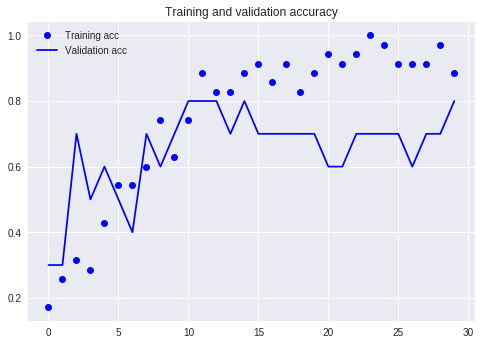

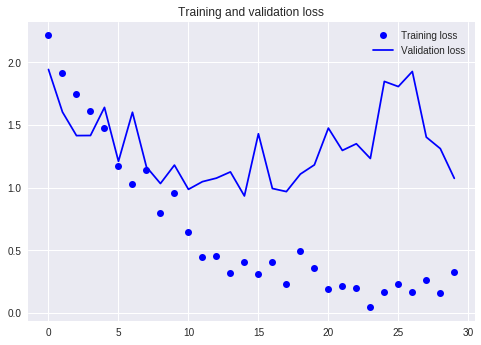

In [0]:
# Call Plotter Function to display the results

plotter(history)

### Observable Results

After running the model for 30 epochs/iterations, we obtained the following results:

- Training Accuracy: 97%
- Validation Accuracy: 80%

Used Parameters:

- No. of epochs: 30
- Batches: 5

### Experiment 4: Train a simple Dense Neural Network using a Google Downloaded Fruit Dataset with Google Downloaded Augmented Dataset and Kaggle Dataset

- Dense Neural Network with 3 Input Layers and 64 units/nodes each
- Output: Softmax

In [0]:
# Base Directory

base_dir = '../content/gdrive/My Drive/Fruit Classifier/google-fruits-augmented-kaggle-fruits'

# Specify training, validation and testing directories

train_dir = base_dir + '/train'
valid_dir = base_dir + '/validation'
test_dir = base_dir + '/test'

In [0]:
# Extract features and labels

train_features, train_labels = extract_features(train_dir, 35)
validation_features, validation_labels = extract_features(valid_dir, 10)
test_features, test_labels = extract_features(test_dir, 5)

Found 3156 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Found 30 images belonging to 6 classes.


In [0]:
# Reshape feature vectors to fit into ML models

train_features = np.reshape(train_features, (35, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (10, 4 * 4 * 512))
test_features = np.reshape(test_features, (5, 4 * 4 * 512))

In [0]:
# Create new model

model, history = network_creation(train_features, train_labels, validation_features, validation_labels, test_features, test_labels, 35)

Train on 35 samples, validate on 10 samples
Epoch 1/35
35/35 [==============================] - 0s 14ms/step - loss: 2.6385 - acc: 0.2000 - val_loss: 1.6641 - val_acc: 0.2000
Epoch 2/35
35/35 [==============================] - 0s 3ms/step - loss: 1.5982 - acc: 0.3714 - val_loss: 1.5782 - val_acc: 0.3000
Epoch 3/35
35/35 [==============================] - 0s 3ms/step - loss: 1.4621 - acc: 0.4571 - val_loss: 1.8728 - val_acc: 0.3000
Epoch 4/35
35/35 [==============================] - 0s 3ms/step - loss: 1.2970 - acc: 0.5714 - val_loss: 1.4277 - val_acc: 0.5000
Epoch 5/35
35/35 [==============================] - 0s 3ms/step - loss: 1.2944 - acc: 0.6000 - val_loss: 1.4446 - val_acc: 0.3000
Epoch 6/35
35/35 [==============================] - 0s 3ms/step - loss: 0.9020 - acc: 0.7143 - val_loss: 1.4172 - val_acc: 0.3000
Epoch 7/35
35/35 [==============================] - 0s 3ms/step - loss: 1.0439 - acc: 0.5714 - val_loss: 1.5100 - val_acc: 0.3000
Epoch 8/35
35/35 [===========================

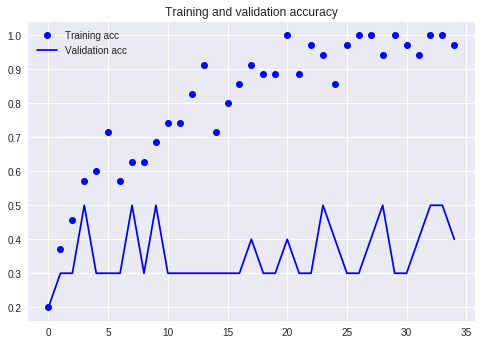

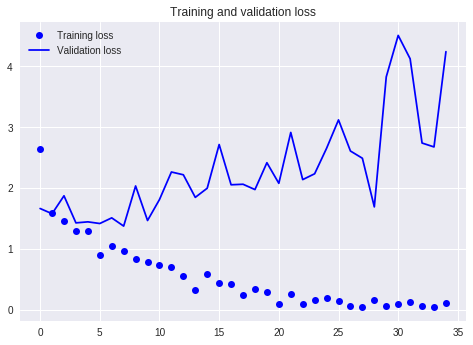

In [0]:
# Call Plotter Function to display the results

plotter(history)

### Observable Results

After running the model for 30 epochs/iterations, we obtained the following results:

- Training Accuracy: 100%
- Validation Accuracy: 50%

Used Parameters:
- No. of epochs: 30
- Batches: 5

### Experiment 5: Train a Convolutional Neural Network using a Google Downloaded Fruit Dataset 

- Input shape 100x100x3
- Feed CNN into a 1 layer Regular Dense Network

In [0]:
# Base Directory

base_dir = '../content/gdrive/My Drive/Fruit Classifier/google-fruits'

# Specify training, validation and testing directories

train_dir = base_dir + '/train'
valid_dir = base_dir + '/validation'
test_dir = base_dir + '/test'

In [0]:
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

# Specify CNN netwrk creation

def network_cnn_creation(train_dir, valid_dir, test_dir, img_size):

  # Specify network type: Sequential Model

  model = models.Sequential()

  # add 2D convolutional layer with 16 3x3x3 filters (Input is 100x100 color image)
  # Input: 100x100x3
  # Output: (100-3+1) x (100-3+1) x 16 = 98x98x16

  model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(img_size, img_size, 3)))

  # add 2x2 max pooling layer
  # Output: 98/2 x 98/2 x 16 = 49x49x16

  model.add(layers.MaxPooling2D((2,2)))

  # add 2D convolutional layer with 16 3x3x16 filters
  # Output: (49-3+1)x(49-3+1)x16 = 47x47x16

  model.add(layers.Conv2D(16, (3,3), activation='relu'))
  
  # Add Dropout
  
  model.add(layers.Dropout(0.5))


  # add 2x2 max pooling layer
  # Output: 47/2 x 47/2 x 16 = 23x23x16

  model.add(layers.MaxPooling2D((2,2)))

  # add 2D convolutional layer with 64 3x3x64 filters
  # Output: (23-3+1)x(23-3+1)x64 = 21x21x64 

  model.add(layers.Conv2D(64, (3,3), activation='relu'))

  # add 2x2 max pooling layer
  # Output: 21/2 x 21/2 x 64 = 10x10x64

  model.add(layers.MaxPooling2D((2,2)))


  # flatten output to 1D
  # Output: 10*10*64 = 7396

  model.add(layers.Flatten())          

  # add dense layer with 128 hidden units
  # Output: 128

  model.add(layers.Dense(128, activation='relu'))          

  # since categorical classification problem:
  # -> 6 output units
  # -> Use softmax activation function

  model.add(layers.Dense(6, activation='softmax'))


  # Compile network
  # Loss/Cost Function: Categorical Crossentropy -> Seeing that it is a multi-class classification problem
  # Optimizer: Back-propagation
  # Metric: Accuracy

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(lr=1e-4),
                metrics=['accuracy'])
  
  # All images will be rescaled by 1./255

  train_datagen = ImageDataGenerator(rescale=1./255)
  valid_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(  

          # Target directory
          train_dir,
          target_size=(100, 100),
          batch_size=5,

          # Since we use categorical_crossentropy loss, we need 2D one-hot encoded labels
          class_mode='categorical')

  validation_generator = valid_datagen.flow_from_directory(
          valid_dir,
          target_size=(100, 100),
          batch_size=5,
          class_mode='categorical')
  
  history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=15)
  
  return model, history

In [0]:
# Call CNN network creation function to create network

# Specify img size

IMG_SIZE = 100

model, history = network_cnn_creation(train_dir, valid_dir, test_dir, IMG_SIZE)

Found 210 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Epoch 1/30
10/10 [==============================] - 9s 945ms/step - loss: 1.9070 - acc: 0.2000 - val_loss: 1.7709 - val_acc: 0.2000
Epoch 2/30
10/10 [==============================] - 9s 887ms/step - loss: 1.7880 - acc: 0.2000 - val_loss: 1.7950 - val_acc: 0.2000
Epoch 3/30
10/10 [==============================] - 11s 1s/step - loss: 1.8517 - acc: 0.1800 - val_loss: 1.7681 - val_acc: 0.1867
Epoch 4/30
10/10 [==============================] - 10s 959ms/step - loss: 1.7886 - acc: 0.2000 - val_loss: 1.7593 - val_acc: 0.2400
Epoch 5/30
10/10 [==============================] - 3s 326ms/step - loss: 1.7245 - acc: 0.2400 - val_loss: 1.7615 - val_acc: 0.1467
Epoch 6/30
10/10 [==============================] - 1s 112ms/step - loss: 1.6943 - acc: 0.2400 - val_loss: 1.7339 - val_acc: 0.2667
Epoch 7/30
10/10 [==============================] - 1s 127ms/step - loss: 1.6928 - acc: 0.2600 - val_loss: 1.7296 - val_acc: 0.2

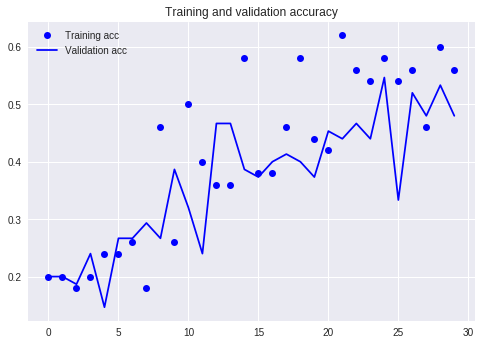

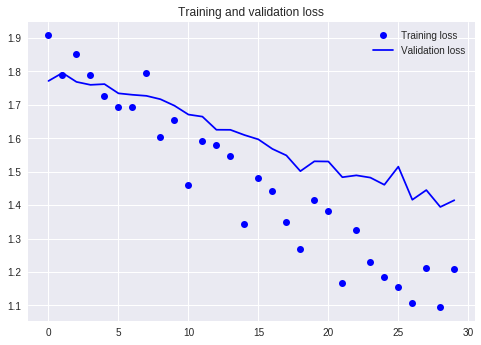

In [0]:
# Call Plotter Function to display the results

plotter(history)

### Observable Results

After running the model for 30 epochs/iterations, we obtained the following results:

- Training Accuracy: 60%
- Validation Accuracy: 54%

Used Parameters:
- Steps per epochs: 10
- No. of epochs: 30
- Validation Steps: 15

### Experiment 6: Train a Convolutional Neural Network using a Google Downloaded Fruit Dataset with Kaggle Dataset

- Input shape 100x100x3
- Feed CNN into a 1 layer Regular Dense Network

In [0]:
# Base Directory

base_dir = '../content/gdrive/My Drive/Fruit Classifier/google-fruits-kaggle-fruits'

# Specify training, validation and testing directories

train_dir = base_dir + '/train'
valid_dir = base_dir + '/validation'
test_dir = base_dir + '/test'

In [0]:
# Create the network 

model, history = network_cnn_creation(train_dir, valid_dir, test_dir, IMG_SIZE)

Found 1583 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Epoch 1/30
10/10 [==============================] - 15s 2s/step - loss: 1.8950 - acc: 0.2000 - val_loss: 1.8210 - val_acc: 0.2667
Epoch 2/30
10/10 [==============================] - 12s 1s/step - loss: 1.7288 - acc: 0.3400 - val_loss: 1.8026 - val_acc: 0.2267
Epoch 3/30
10/10 [==============================] - 11s 1s/step - loss: 1.6805 - acc: 0.3600 - val_loss: 1.8310 - val_acc: 0.1200
Epoch 4/30
10/10 [==============================] - 11s 1s/step - loss: 1.5342 - acc: 0.4400 - val_loss: 1.7908 - val_acc: 0.2133
Epoch 5/30
10/10 [==============================] - 12s 1s/step - loss: 1.4731 - acc: 0.5000 - val_loss: 1.8141 - val_acc: 0.1600
Epoch 6/30
10/10 [==============================] - 11s 1s/step - loss: 1.4194 - acc: 0.6000 - val_loss: 1.8085 - val_acc: 0.1867
Epoch 7/30
10/10 [==============================] - 13s 1s/step - loss: 1.3669 - acc: 0.3800 - val_loss: 1.7549 - val_acc: 0.2133
Epoch 8/

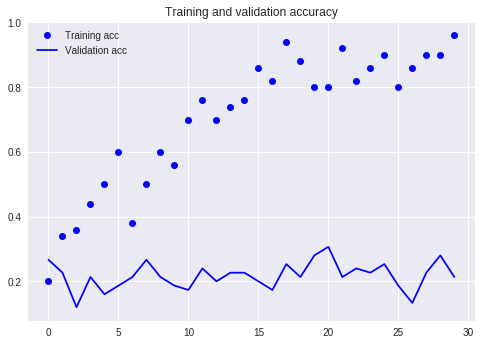

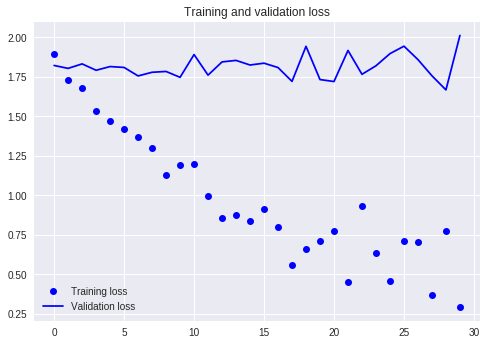

In [0]:
# Call Plotter Function to display the results

plotter(history)

### Observable Results

After running the model for 30 epochs/iterations, we obtained the following results:

- Training Accuracy: 96%
- Validation Accuracy: 30%

Used Parameters:
- Steps per epochs: 10
- No. of epochs: 30
- Validation Steps: 15

### Experiment 7: Train a Convolutional Neural Network using a Google Downloaded Fruit Dataset with Google Downloaded Augmented Dataset

- Input shape 100x100x3
- Feed CNN into a 1 layer Regular Dense Network

In [0]:
# Base Directory

base_dir = '../content/gdrive/My Drive/Fruit Classifier/google-fruits-augmented'

# Specify training, validation and testing directories

train_dir = base_dir + '/train'
valid_dir = base_dir + '/validation'
test_dir = base_dir + '/test'

In [0]:
# Create the network 

model, history = network_cnn_creation(train_dir, valid_dir, test_dir, IMG_SIZE)

Found 1506 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Epoch 1/30
10/10 [==============================] - 10s 1s/step - loss: 1.9822 - acc: 0.1800 - val_loss: 1.8118 - val_acc: 0.1600
Epoch 2/30
10/10 [==============================] - 10s 969ms/step - loss: 1.8918 - acc: 0.1400 - val_loss: 1.7807 - val_acc: 0.2533
Epoch 3/30
10/10 [==============================] - 11s 1s/step - loss: 1.7817 - acc: 0.2000 - val_loss: 1.7829 - val_acc: 0.2933
Epoch 4/30
10/10 [==============================] - 9s 913ms/step - loss: 1.7889 - acc: 0.2400 - val_loss: 1.7713 - val_acc: 0.3067
Epoch 5/30
10/10 [==============================] - 10s 1s/step - loss: 1.8253 - acc: 0.2000 - val_loss: 1.7680 - val_acc: 0.2533
Epoch 6/30
10/10 [==============================] - 12s 1s/step - loss: 1.8297 - acc: 0.2200 - val_loss: 1.7567 - val_acc: 0.2933
Epoch 7/30
10/10 [==============================] - 10s 988ms/step - loss: 1.7730 - acc: 0.1800 - val_loss: 1.7639 - val_acc: 0.1733


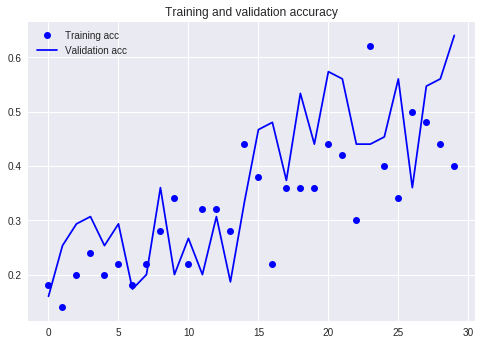

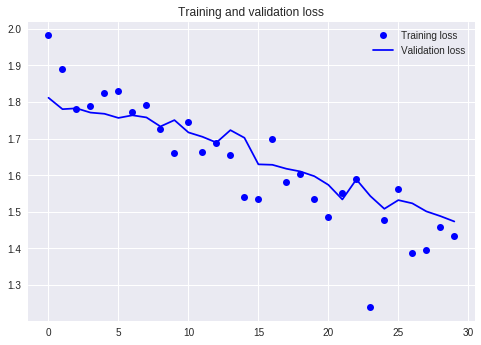

In [0]:
# Call Plotter Function to display the results

plotter(history)

### Observable Results

After running the model for 30 epochs/iterations, we obtained the following results:

- Training Accuracy: 50%
- Validation Accuracy: 64%

Used Parameters:
- Steps per epochs: 10
- No. of epochs: 30
- Validation Steps: 15

### Experiment 8: Train a Convolutional Neural Network using a Google Downloaded Fruit Dataset with Google Downloaded Augmented Dataset and Kaggle Dataset

- Input shape 100x100x3
- Feed CNN into a 1 layer Regular Dense Network

In [0]:
# Base Directory

base_dir = '../content/gdrive/My Drive/Fruit Classifier/google-fruits-augmented-kaggle-fruits'

# Specify training, validation and testing directories

train_dir = base_dir + '/train'
valid_dir = base_dir + '/validation'
test_dir = base_dir + '/test'

In [0]:
# Create the network 

model, history = network_cnn_creation(train_dir, valid_dir, test_dir, IMG_SIZE)

Found 3156 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Epoch 1/30
10/10 [==============================] - 12s 1s/step - loss: 1.8326 - acc: 0.1800 - val_loss: 1.7847 - val_acc: 0.2400
Epoch 2/30
10/10 [==============================] - 8s 789ms/step - loss: 1.7792 - acc: 0.2200 - val_loss: 1.7829 - val_acc: 0.2400
Epoch 3/30
10/10 [==============================] - 9s 943ms/step - loss: 1.7771 - acc: 0.3000 - val_loss: 1.7751 - val_acc: 0.1867
Epoch 4/30
10/10 [==============================] - 9s 877ms/step - loss: 1.6744 - acc: 0.2400 - val_loss: 1.7935 - val_acc: 0.1600
Epoch 5/30
10/10 [==============================] - 9s 904ms/step - loss: 1.7615 - acc: 0.3200 - val_loss: 1.7658 - val_acc: 0.2133
Epoch 6/30
10/10 [==============================] - 9s 879ms/step - loss: 1.6468 - acc: 0.3600 - val_loss: 1.7644 - val_acc: 0.2800
Epoch 7/30
10/10 [==============================] - 8s 843ms/step - loss: 1.6370 - acc: 0.3200 - val_loss: 1.7509 - val_acc: 0.1

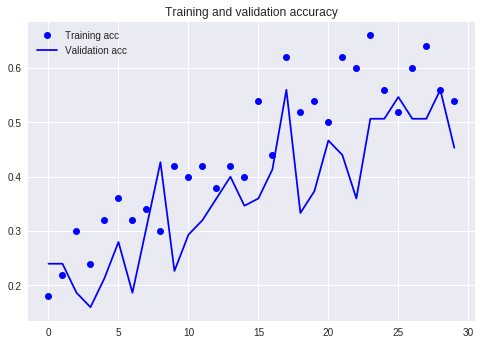

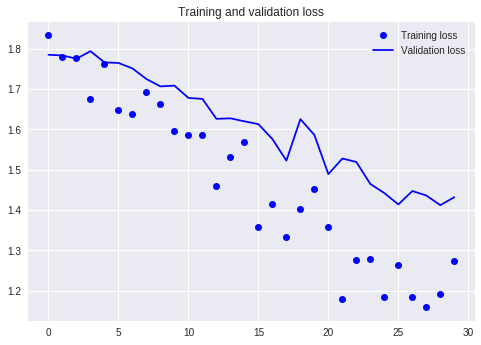

In [0]:
# Call Plotter Function to display the results

plotter(history)

### Observable Results

After running the model for 30 epochs/iterations, we obtained the following results:

- Training Accuracy: 66%
- Validation Accuracy: 56%

Used Parameters:
- Steps per epochs: 10
- No. of epochs: 30
- Validation Steps: 15

### Experiment 9: Train a Pre-Trained Convolutional Neural Network using a Google Downloaded Fruit Dataset 

- Keras MobileNet Image Classification model
- Freeze the weights of the Pre-trained model because those weights would have already valuable weighted values (i.e. features)
- Attach Pre-trained model to regular NN
- Regularization and Dropout to reduce overfitting


In [0]:
# Import pre-trained Convolution Neural Network

from keras.applications import MobileNet
from keras import regularizers

mobile_model = MobileNet(weights='imagenet', include_top=False, input_shape = (128, 128, 3))

17227776/17225924 [==============================] - 0s 0us/step


In [0]:
# Base Directory

base_dir = '../content/gdrive/My Drive/Fruit Classifier/google-fruits'

# Specify training, validation and testing directories

train_dir = base_dir + '/train'
valid_dir = base_dir + '/validation'
test_dir = base_dir + '/test'

In [0]:
def create_pretrained_network(train_dir, valid_dir, test_dir):

  # Create regular neural network

  network = models.Sequential()

  # Add Convolution layers to regular neural network

  network.add(mobile_model)

  # Flatten convolutional layers to feed into regular neural network

  network.add(layers.Flatten())

  network.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))

  network.add(layers.Dropout(0.5))

  network.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))

  network.add(layers.Dense(6, activation='softmax'))

  # Freeze learned weight from the mobile_net convolutional network

  mobile_model.trainable = False
  
  # All images will be rescaled by 1./255

  train_datagen = ImageDataGenerator(rescale=1./255)
  valid_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(  

          # Target directory
          train_dir,
          target_size=(128, 128),
          batch_size=5,

          # Since we use categorical_crossentropy loss, we need 2D one-hot encoded labels
          class_mode='categorical')

  valid_generator = valid_datagen.flow_from_directory(
          valid_dir,
          target_size=(128, 128),
          batch_size=5,
          class_mode='categorical')

  # Compile network and start training

  network.compile(
      optimizer=optimizers.RMSprop(lr=1e-4),
      loss='categorical_crossentropy',
      metrics=['accuracy'])


  history = network.fit_generator(
        train_generator,
        steps_per_epoch=10,
        epochs=30,
        validation_data=valid_generator,
        validation_steps=15)
  
  return network, history

In [0]:
# Create the Pre-Train Network

pre_network, history = create_pretrained_network(train_dir, valid_dir, test_dir)

Found 210 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Epoch 1/30
10/10 [==============================] - 7s 748ms/step - loss: 3.5093 - acc: 0.1200 - val_loss: 1.9999 - val_acc: 0.2533
Epoch 2/30
10/10 [==============================] - 5s 491ms/step - loss: 2.0688 - acc: 0.3600 - val_loss: 1.8779 - val_acc: 0.3467
Epoch 3/30
10/10 [==============================] - 5s 501ms/step - loss: 2.3904 - acc: 0.3400 - val_loss: 1.4700 - val_acc: 0.6667
Epoch 4/30
10/10 [==============================] - 5s 492ms/step - loss: 2.1757 - acc: 0.3800 - val_loss: 1.3568 - val_acc: 0.6533
Epoch 5/30
10/10 [==============================] - 5s 491ms/step - loss: 1.8087 - acc: 0.4400 - val_loss: 1.2846 - val_acc: 0.7600
Epoch 6/30
10/10 [==============================] - 5s 509ms/step - loss: 1.2194 - acc: 0.6200 - val_loss: 1.2643 - val_acc: 0.7067
Epoch 7/30
10/10 [==============================] - 5s 506ms/step - loss: 1.6221 - acc: 0.6000 - val_loss: 1.3233 - val_acc: 0.

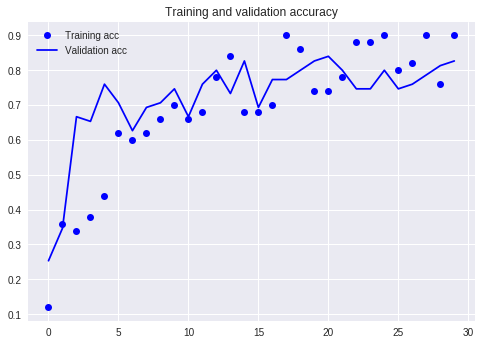

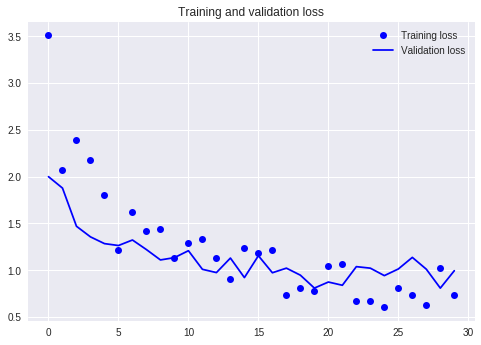

In [0]:
# Call Plotter Function to display the results

plotter(history)

### Observable Results

After running the model for 30 epochs/iterations, we obtained the following results:

- Training Accuracy: 90%
- Validation Accuracy: 82%

Used Parameters:
- Steps per epochs: 10
- No. of epochs: 30
- Validation Steps: 15

### Experiment 10: Train a Pre-Trained Convolutional Neural Network using a Google Downloaded Fruit Dataset and Kaggle Dataset

- Keras MobileNet Image Classification model
- Freeze the weights of the Pre-trained model because those weights would have already valuable weighted values (i.e. features)
- Attach Pre-trained model to regular NN
- Regularization and Dropout to reduce overfitting


In [0]:
# Base Directory

base_dir = '../content/gdrive/My Drive/Fruit Classifier/google-fruits-kaggle-fruits'

# Specify training, validation and testing directories

train_dir = base_dir + '/train'
valid_dir = base_dir + '/validation'
test_dir = base_dir + '/test'

In [0]:
# Create the Pre-Train Network

pre_network, history = create_pretrained_network(train_dir, valid_dir, test_dir)

Found 1583 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Epoch 1/30
10/10 [==============================] - 8s 766ms/step - loss: 3.0229 - acc: 0.3600 - val_loss: 2.4990 - val_acc: 0.2800
Epoch 2/30
10/10 [==============================] - 5s 487ms/step - loss: 1.9474 - acc: 0.4800 - val_loss: 2.0809 - val_acc: 0.4133
Epoch 3/30
10/10 [==============================] - 5s 480ms/step - loss: 1.1962 - acc: 0.7200 - val_loss: 1.9647 - val_acc: 0.4133
Epoch 4/30
10/10 [==============================] - 5s 488ms/step - loss: 1.5283 - acc: 0.5600 - val_loss: 2.0287 - val_acc: 0.3467
Epoch 5/30
10/10 [==============================] - 5s 486ms/step - loss: 1.0232 - acc: 0.7800 - val_loss: 1.9028 - val_acc: 0.3867
Epoch 6/30
10/10 [==============================] - 5s 476ms/step - loss: 1.0338 - acc: 0.8000 - val_loss: 1.9220 - val_acc: 0.4133
Epoch 7/30
10/10 [==============================] - 5s 481ms/step - loss: 1.2277 - acc: 0.7400 - val_loss: 1.8824 - val_acc: 0

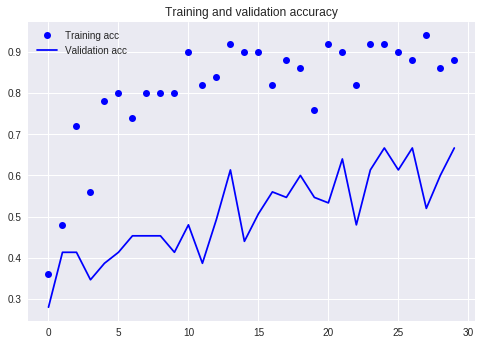

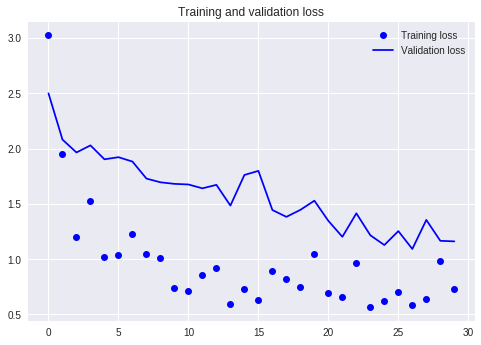

In [0]:
# Call Plotter Function to display the results

plotter(history)

### Observable Results

After running the model for 30 epochs/iterations, we obtained the following results:

- Training Accuracy: 94%
- Validation Accuracy: 66%

Used Parameters:
- Steps per epochs: 10
- No. of epochs: 30
- Validation Steps: 15

### Experiment 11: Train a Pre-Trained Convolutional Neural Network using a Google Downloaded Fruit Dataset and Google Downloaded Augmented Dataset

- Keras MobileNet Image Classification model
- Freeze the weights of the Pre-trained model because those weights would have already valuable weighted values (i.e. features)
- Attach Pre-trained model to regular NN
- Regularization and Dropout to reduce overfitting


In [0]:
# Base Directory

base_dir = '../content/gdrive/My Drive/Fruit Classifier/google-fruits-augmented'

# Specify training, validation and testing directories

train_dir = base_dir + '/train'
valid_dir = base_dir + '/validation'
test_dir = base_dir + '/test'

In [0]:
# Create the Pre-Train Network

pre_network, history = create_pretrained_network(train_dir, valid_dir, test_dir)

Found 1506 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Epoch 1/30
10/10 [==============================] - 8s 797ms/step - loss: 3.0971 - acc: 0.2400 - val_loss: 2.0030 - val_acc: 0.3733
Epoch 2/30
10/10 [==============================] - 5s 486ms/step - loss: 3.2049 - acc: 0.1800 - val_loss: 1.9689 - val_acc: 0.3333
Epoch 3/30
10/10 [==============================] - 5s 487ms/step - loss: 2.2811 - acc: 0.1800 - val_loss: 1.8457 - val_acc: 0.5067
Epoch 4/30
10/10 [==============================] - 5s 486ms/step - loss: 2.2159 - acc: 0.3400 - val_loss: 1.7585 - val_acc: 0.4800
Epoch 5/30
10/10 [==============================] - 5s 484ms/step - loss: 1.8421 - acc: 0.4600 - val_loss: 1.6842 - val_acc: 0.4800
Epoch 6/30
10/10 [==============================] - 5s 485ms/step - loss: 1.7381 - acc: 0.5200 - val_loss: 1.4090 - val_acc: 0.6800
Epoch 7/30
10/10 [==============================] - 5s 481ms/step - loss: 2.2157 - acc: 0.4000 - val_loss: 1.2291 - val_acc: 0

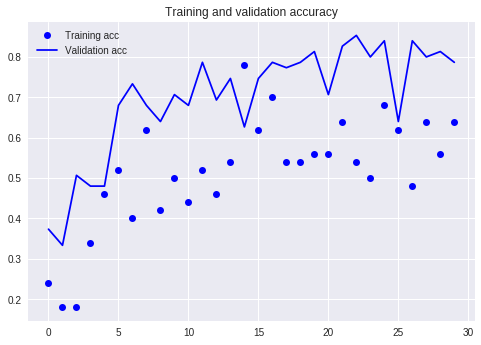

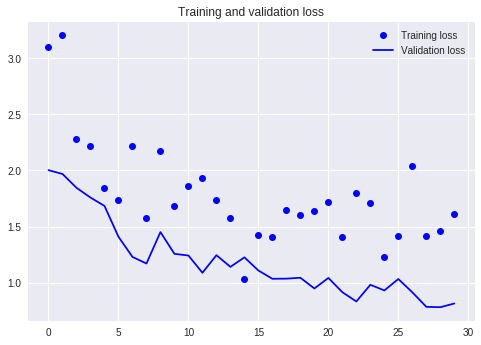

In [0]:
# Call Plotter Function to display the results

plotter(history)

### Observable Results

After running the model for 30 epochs/iterations, we obtained the following results:

- Training Accuracy: 78%
- Validation Accuracy: 85%

Used Parameters:
- Steps per epochs: 10
- No. of epochs: 30
- Validation Steps: 15 

### Experiment 12: Train a Pre-Trained Convolutional Neural Network using a Google Downloaded Fruit Dataset and Google Downloaded Augmented Dataset and Kaggle Dataset

- Keras MobileNet Image Classification model
- Freeze the weights of the Pre-trained model because those weights would have already valuable weighted values (i.e. features)
- Attach Pre-trained model to regular NN
- Regularization and Dropout to reduce overfitting


In [0]:
# Base Directory

base_dir = '../content/gdrive/My Drive/Fruit Classifier/google-fruits-augmented-kaggle-fruits'

# Specify training, validation and testing directories

train_dir = base_dir + '/train'
valid_dir = base_dir + '/validation'
test_dir = base_dir + '/test'

In [0]:
# Create the Pre-Train Network

pre_network, history = create_pretrained_network(train_dir, valid_dir, test_dir)

Found 3156 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Epoch 1/30
10/10 [==============================] - 9s 881ms/step - loss: 3.5937 - acc: 0.1200 - val_loss: 1.9515 - val_acc: 0.3600
Epoch 2/30
10/10 [==============================] - 5s 486ms/step - loss: 2.4491 - acc: 0.2400 - val_loss: 1.8255 - val_acc: 0.4400
Epoch 3/30
10/10 [==============================] - 5s 485ms/step - loss: 2.6448 - acc: 0.3000 - val_loss: 1.8421 - val_acc: 0.4133
Epoch 4/30
10/10 [==============================] - 5s 484ms/step - loss: 2.2360 - acc: 0.3400 - val_loss: 1.7056 - val_acc: 0.4400
Epoch 5/30
10/10 [==============================] - 5s 484ms/step - loss: 2.3997 - acc: 0.3000 - val_loss: 1.6760 - val_acc: 0.5200
Epoch 6/30
10/10 [==============================] - 5s 482ms/step - loss: 2.0896 - acc: 0.3800 - val_loss: 1.4429 - val_acc: 0.6267
Epoch 7/30
10/10 [==============================] - 5s 491ms/step - loss: 1.7041 - acc: 0.4400 - val_loss: 1.5507 - val_acc: 0

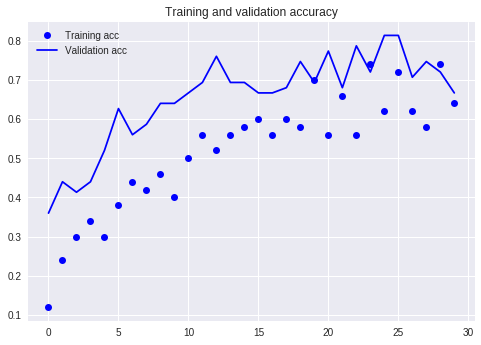

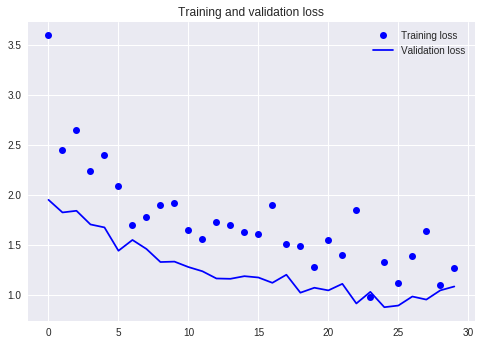

In [0]:
# Call Plotter Function to display the results

plotter(history)

### Observable Results

After running the model for 30 epochs/iterations, we obtained the following results:

- Training Accuracy: 74%
- Validation Accuracy: 81%

Used Parameters:
- Steps per epochs: 10
- No. of epochs: 30
- Validation Steps: 15

### Experiment 12: Train Best Neural Network 

Out of all the trained neural network the MobileNet Pretrained Network with Google Downloaded Dataset and Google Downloaded Augmented Dataset gave the best performance via the metric of accuracy on the validation set.

- Train on the entire Google Downloaded Training Set with the Google Augmented Data
- Evaluate on the Google Downloaded Test Set


In [0]:
# Base Directory

base_dir = '../content/gdrive/My Drive/Fruit Classifier/google-fruits'

# Specify training, validation and testing directories

train_dir = base_dir + '/full-train'
test_dir = base_dir + '/test'

In [0]:
def best_network(train_dir):

  # Create regular neural network

  network = models.Sequential()

  # Add Convolution layers to regular neural network

  network.add(mobile_model)

  # Flatten convolutional layers to feed into regular neural network

  network.add(layers.Flatten())

  network.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))

  network.add(layers.Dropout(0.5))

  network.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))

  network.add(layers.Dense(6, activation='softmax'))

  # Freeze learned weight from the mobile_net convolutional network

  mobile_model.trainable = False
  
  # All images will be rescaled by 1./255

  train_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(  

          # Target directory
          train_dir,
          target_size=(128, 128),
          batch_size=5,

          # Since we use categorical_crossentropy loss, we need 2D one-hot encoded labels
          class_mode='categorical')
  
  # Compile network and start training

  network.compile(
      optimizer=optimizers.RMSprop(lr=1e-4),
      loss='categorical_crossentropy',
      metrics=['accuracy'])


  history = network.fit_generator(
        train_generator,
        steps_per_epoch=10,
        epochs=30)
  
  return network, history

In [0]:
best_net, history = best_network(train_dir)

Found 2148 images belonging to 6 classes.
Epoch 1/30
10/10 [==============================] - 8s 798ms/step - loss: 3.2653 - acc: 0.2600
Epoch 2/30
10/10 [==============================] - 9s 861ms/step - loss: 3.1866 - acc: 0.2800
Epoch 3/30
10/10 [==============================] - 9s 885ms/step - loss: 2.4763 - acc: 0.3800
Epoch 4/30
10/10 [==============================] - 9s 863ms/step - loss: 2.6136 - acc: 0.3200
Epoch 5/30
10/10 [==============================] - 9s 857ms/step - loss: 2.5239 - acc: 0.2600
Epoch 6/30
10/10 [==============================] - 9s 892ms/step - loss: 1.9974 - acc: 0.4400
Epoch 7/30
10/10 [==============================] - 8s 816ms/step - loss: 2.3742 - acc: 0.3600
Epoch 8/30
10/10 [==============================] - 8s 834ms/step - loss: 2.3904 - acc: 0.2600
Epoch 9/30
10/10 [==============================] - 8s 823ms/step - loss: 2.1520 - acc: 0.3200
Epoch 10/30
10/10 [==============================] - 8s 815ms/step - loss: 1.6380 - acc: 0.5400
Epoch 1

In [0]:
# Define smooth curve function

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

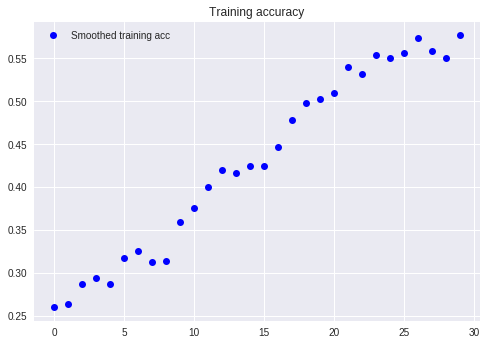

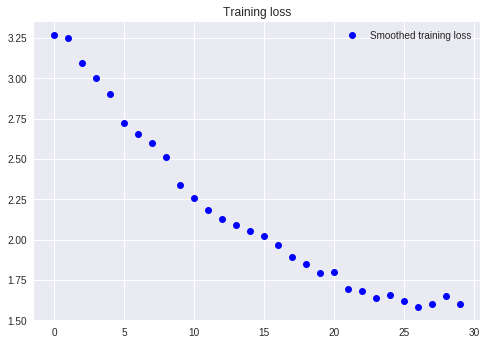

In [0]:
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [0]:
# Evaluate best model on the test set
# Output Accuracy

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        batch_size=10,
        class_mode='categorical')

test_loss, test_acc = best_net.evaluate_generator(test_generator, steps=15)

Found 30 images belonging to 6 classes.


In [0]:
# Output test accuracy and loss

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

Test accuracy: 0.6666666726271312
Test loss: 1.1726953625679015


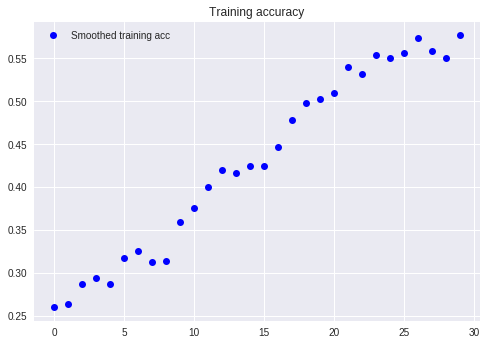

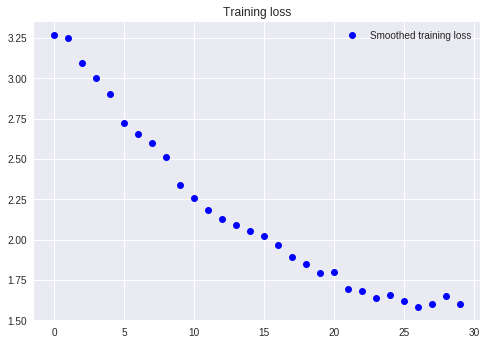

In [0]:
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(test_acc))

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed test acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(test_loss), 'bo', label='Smoothed test loss')
plt.title('Training loss')
plt.legend()

plt.show()

### Final Observable Results

After running the model for 30 epochs/iterations, we obtained the following results:

- Training Accuracy: 68%
- Test Accuracy: 66%

Used Parameters:
- Steps per epochs: 10
- No. of epochs: 30

In conclusion it can be said that given the nature of the problem, an accuracy of 66% on the testing set using a Pre-Trained Neural Network and a dataset of approximately 2400 images is pretty acceptable.